# Clustering
Let's do classifying and dividing into clusters as an optimization problem.

## What you will learn this time.
1. Clustering using quantum annealing
2. Clustering using QAOA

## Install Blueqat
Install Blueqat using pip

In [1]:
!pip install blueqat

numba 0.49.0 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Overview
Clustering in the optimization problem is

Blue is a cluster, red is a qubit, and the thick black line represents that one of the three red qubits is selected. Yellow line is used for weighting between nodes by distance and so on.

<div>
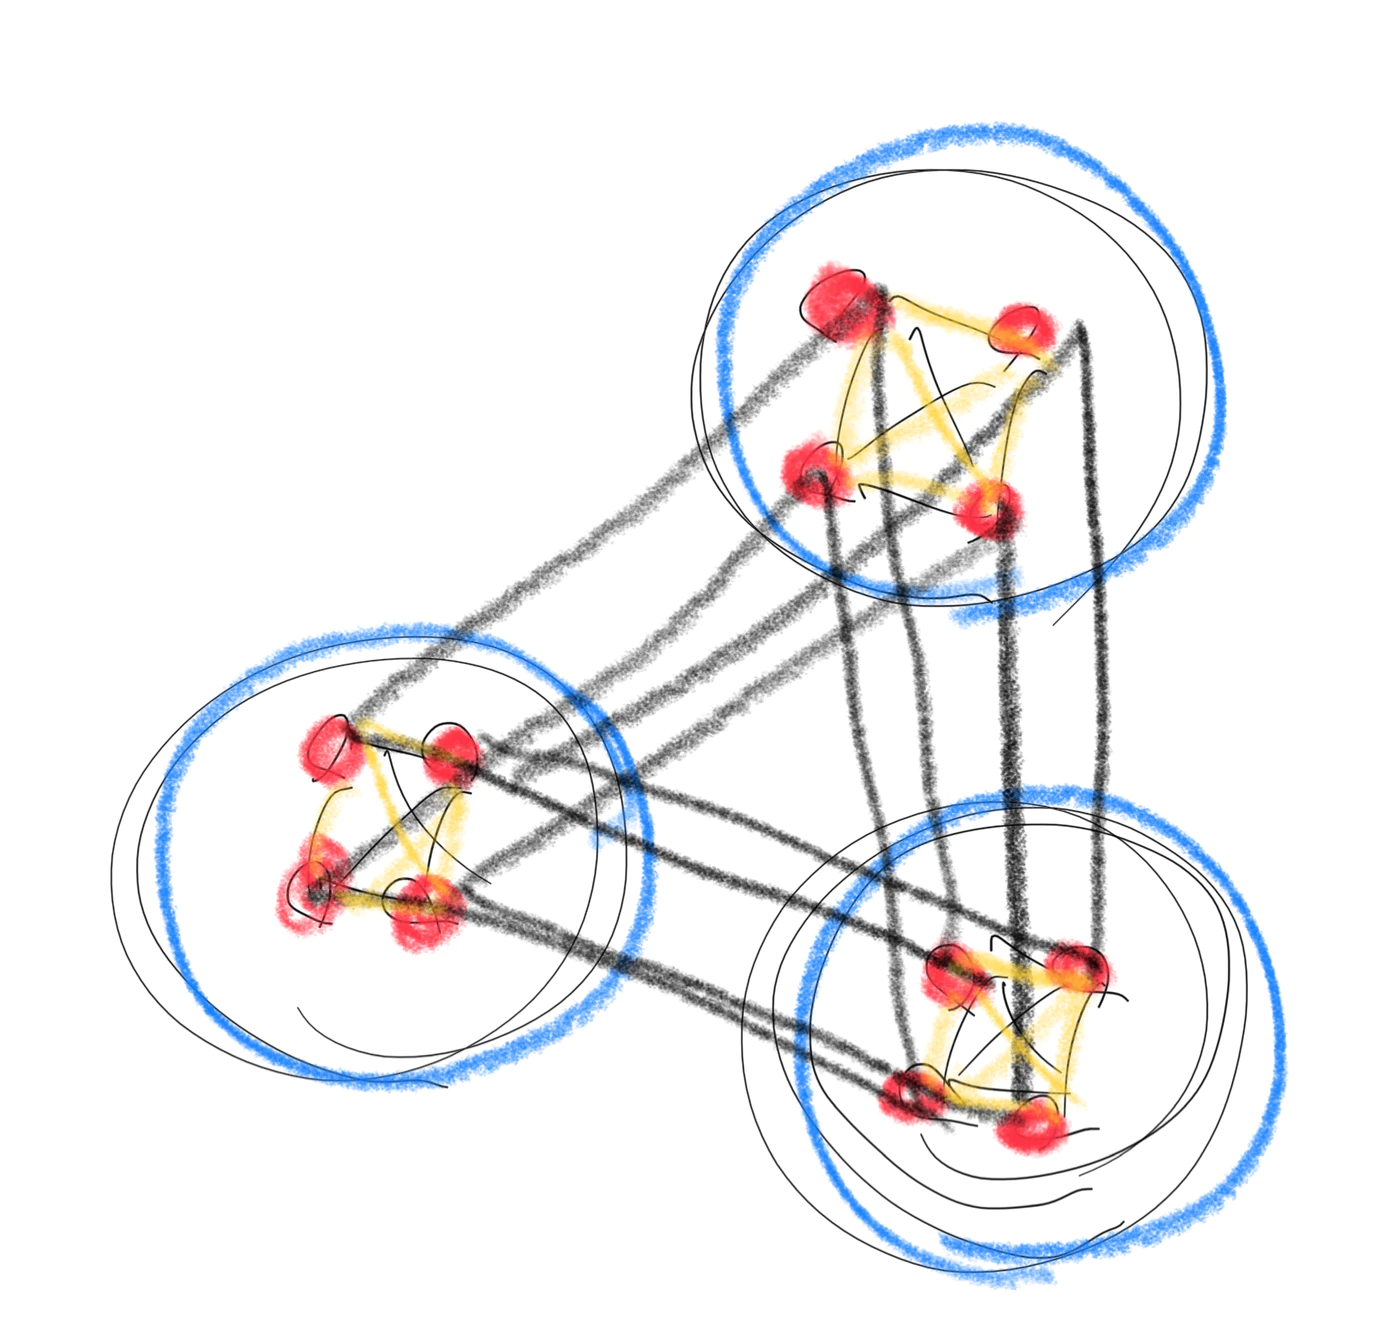
</div>

In this tutorial, let's cluster the randomly set points with D-Wave's Leap2.

## Example
The four nodes are divided into two clusters. The number of qubits required is 4 * 2 = 8.  

For the eight qubits of $q_0, q_1, q_2, q_3, q_4, q_5, q_6$, and $q_7$, $q_0$ and $q_4$, $q_1$ and $q_5$, $q_2$ and $q_6$, and $q_3$ and $q_7$ represent the same nodes, the value of the qubit representing the cluster to which it belongs is set to 1, and the other is set to 0.

Nodes and edges refer to Network Figure 1 in the middle of the example.

The lesser of the sum of distances between nodes in the cluster is chosen.

$$
Cost = \sum d_{ij} x_i x_j
$$

The constraint is that only one of the qubits representing the same node will be 1 and the rest will be 0.
$$
Constraint = \sum(\sum_{i=1}^{n_{cluster}} x_{i} - 1)^2
$$

First, load the tool.

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from blueqat.wq import *
import matplotlib.pyplot as plt
%matplotlib inline

First, create the data.  
In this tutorial, let's do a simple problem that divides 4 nodes into 2 clusters.

In [3]:
n_node = 4
n_cluster = 2
N = n_node*n_cluster

print('nodes',n_node)
print('clusters',n_cluster)
print('qubits',N)

nodes 4
clusters 2
qubits 8


Create the data in coordinates so that it is moderately spread out.

In [4]:
x,y = [],[]

for i in range(n_cluster):
    x = np.append(x, np.random.normal(np.random.randint(0,n_cluster*10), 1.5, int(n_node/n_cluster)))
    y = np.append(y, np.random.normal(np.random.randint(0,n_cluster*10), 1.5, int(n_node/n_cluster)))

df = pd.DataFrame({'x':x,'y':y})
df

,x,y
0,9.020401,2.086793
1,6.896391,3.567573
2,17.454864,13.024077
3,15.294452,11.772365


Check the distribution of points at the coordinates you have created.

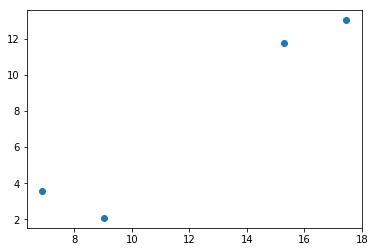

In [5]:
#plot
plt.scatter(df['x'], df['y'])

Prepare the QUBO matrix with the distance setting.

In [6]:
def initCost(data, n_cluster):
    #Create a matrix of distances.
    n_node = len(data)
    d = np.zeros((n_node, n_node))

    #Find the distance from the X and Y coordinates of the data.
    for i in range(0, n_node-1):
        for j in range(i+1, n_node):
            a = np.array([data['x'][i], data['y'][i]])
            b = np.array([data['x'][j], data['y'][j]])
            d[i][j] = np.linalg.norm(a-b)

    #The size of QUBO matrix is (number of qubits) * (the number of qubits.)
    N = n_node*n_cluster
    A = np.zeros((N, N))

    #Duplicate and put as many distances as there are clusters.
    for i in range(0, n_node-1):
        for j in range(i+1, n_node):
            for k in range(n_cluster):
                A[i+k*n_node][j+k*n_node] = d[i][j]
    
    return A, d

In [7]:
A,d = initCost(df, n_cluster)
A

array([[ 0.        ,  2.58923218, 13.81174723, 11.54010552,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 14.17416061, 11.74078568,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.49683073,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.58923218, 13.81174723, 11.54010552],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 14.17416061, 11.74078568],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  2.49683073],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

This time we set the constraints between $q_0$ and $q_4$, $q_1$ and $q_5$, $q_2$ and $q_6$, abd $q_3$ and $q_7$respectively.  
Since they can only belong to one of the clusters, one of the values of each will be 1 and one of them will be 0.

$$
(q_0+q_4 - 1)^2 = -q_0-q_4+2q_0q_4\\
(q_1+q_5 - 1)^2 = -q_1-q_5+2q_1q_5\\
(q_2+q_6 - 1)^2 = -q_2-q_6+2q_2q_6\\
(q_3+q_7 - 1)^2 = -q_3-q_7+2q_3q_7\\
$$

In [8]:
B = np.diag([-1]*N)

for i in range(n_node):
    B[i][i+n_node] = 2
B

array([[-1,  0,  0,  0,  2,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  2,  0,  0],
       [ 0,  0, -1,  0,  0,  0,  2,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  2],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1]])

Network Figure 1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


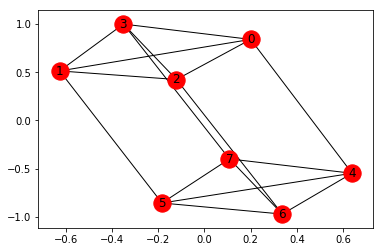

In [9]:
#Create QUBO
M = 1
qubo = A+B*M

#Check by network figure
G = nx.from_numpy_matrix(qubo)
nx.draw_networkx(G)
plt.show()

Determine the value of M and do the calculation.

In [10]:
#blueqatで
M = 10
qubo = A+B*M

a = Opt()
a.qubo = qubo
res = a.run()

res

[1, 1, 0, 0, 0, 0, 1, 1]

Let's check the results of the calculation.

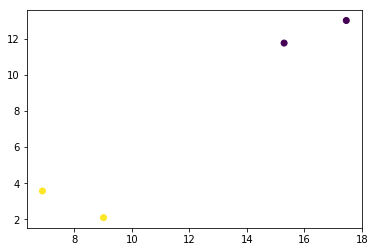

In [11]:
df['cluster'] = res[:4]
plt.scatter(df['x'], df['y'], c=df['cluster'])

## For next, let's try to solve it with QAOA.

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import blueqat
from blueqat import Circuit
from blueqat import vqe,wq
from blueqat.pauli import X,Y,Z

%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


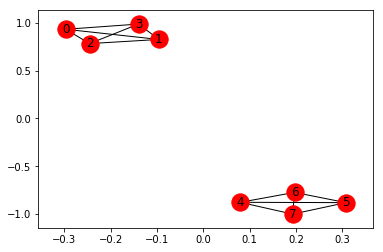

In [19]:
#Create QUBO
qubo = A

#Check by network figure
G = nx.from_numpy_matrix(qubo)
nx.draw_networkx(G)
plt.show()

We don't need any constraint this time.

Determine the constraints with a mixer.
1. Determine the initial entanglement
2. Making XY Mixers

In [20]:
q = wq.pauli(qubo)
step = 2

#mixer and init state
for i in range(n_node):
    if i==0:
        mixer = 0.5*X[0]*X[n_node] + 0.5*Y[0]*Y[n_node]
        init = Circuit().h[0].cx[0,n_node].x[0]
    else:
        mixer += 0.5*X[i]*X[i+n_node] + 0.5*Y[i]*Y[i+n_node]
        init.h[i].cx[i,i+n_node].x[i]

print(mixer)
print(init)

result = vqe.Vqe(vqe.QaoaAnsatz(q, step, init, mixer)).run()
res_qaoa = result.most_common(1)[0][0]
res_qaoa

0.5*X[0]*X[4] + 0.5*Y[0]*Y[4] + 0.5*X[1]*X[5] + 0.5*Y[1]*Y[5] + 0.5*X[2]*X[6] + 0.5*Y[2]*Y[6] + 0.5*X[3]*X[7] + 0.5*Y[3]*Y[7]
Circuit(8).h[0].cx[0, 4].x[0].h[1].cx[1, 5].x[1].h[2].cx[2, 6].x[2].h[3].cx[3, 7].x[3]


(0, 0, 1, 1, 1, 1, 0, 0)

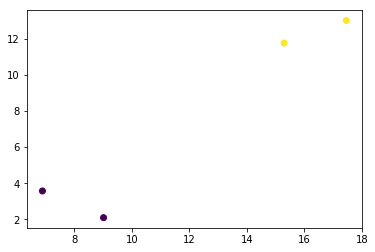

In [21]:
resc = []

for i in range(N):
    if res_qaoa[i] == 1:
        resc.append(int(i/n_node))

df['cluster_qaoa'] = resc

plt.scatter(df['x'], df['y'], c=df['cluster_qaoa'])

In [22]:
result.circuit

Circuit(8).h[0].cx[0, 4].x[0].h[1].cx[1, 5].x[1].h[2].cx[2, 6].x[2].h[3].cx[3, 7].x[3].cx[0, 1].rz(-5.797199933452411)[1].cx[0, 1].cx[0, 2].rz(-30.924017050189324)[2].cx[0, 2].cx[0, 3].rz(-25.837891025910476)[3].cx[0, 3].rz(62.55910800955221)[0].cx[1, 2].rz(-31.735447880582424)[2].cx[1, 2].cx[1, 3].rz(-26.287206873923413)[3].cx[1, 3].rz(63.81985468795825)[1].cx[2, 3].rz(-5.590316323824446)[3].cx[2, 3].rz(68.2497812545962)[2].rz(57.71541422365834)[3].cx[4, 5].rz(-5.797199933452411)[5].cx[4, 5].cx[4, 6].rz(-30.924017050189324)[6].cx[4, 6].cx[4, 7].rz(-25.837891025910476)[7].cx[4, 7].rz(62.55910800955221)[4].cx[5, 6].rz(-31.735447880582424)[6].cx[5, 6].cx[5, 7].rz(-26.287206873923413)[7].cx[5, 7].rz(63.81985468795825)[5].cx[6, 7].rz(-5.590316323824446)[7].cx[6, 7].rz(68.2497812545962)[6].rz(57.71541422365834)[7].h[0].h[4].cx[0, 4].rz(-12.26766485698314)[4].cx[0, 4].h[0].h[4].rx(-1.5707963267948966)[0].rx(-1.5707963267948966)[4].cx[0, 4].rz(-12.26766485698314)[4].cx[0, 4].rx(1.570796326794